# Содержание

1.[Вступление](#cell1)

2.[Подготовка данных](#cell2)
- 2.1 [Замена типов](#cell21)
- 2.2 [Обработка ошибок](#cell22)

3.[Анализ данных](#cell3)

4.[Проверка гипотез](#cell4) 

5.[Выводы](#cell5)

## Описание проекта

Имея данные 500 пользователей сотового оператора об использовании различных услуг и сервисов в 2018 году, необходимо провести анализ двух актуальных тарифов и определить какой тариф более выгоден. Это необходимо для коррекции рекламного бюджета. 

Оператор предлагает два тарифа: Smart за 550 рублей в месяц и тариф Ultra за 1950 рублей. Тарифы отличаются по количеству минут, сообщений и интернет-трафику, включенному в пакет, а также по стоимости дополнительных услуг. В более дорогом тарифе больше минут, сообщений и трафика и ниже цены на услуги связи вне пакетов.

Необходимо также проверить следующие гипотезы:
- средняя выручка пользователей тарифов различается
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

## 1. Вступление
<a id='cell1'></a> 

In [4]:
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv', index_col=0) # чтобы удалить безымянный столбец с повторными индексами
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

In [5]:
calls.shape

(202607, 4)

In [6]:
display(calls.info())
display(internet.info())
display(messages.info())
display(tariffs.info())
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
display(calls.describe())
display(internet.describe())
display(messages.describe())
display(tariffs.describe())
users.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


Всего мы имеем 5 датасетов. В целом во всех наборах по отдельности отсутствуют пропущенные значения, однако, естественно, при объединении данных у ряда пользователей будут такие значения появятся: количество звонков, сообщений и выходов в интернет у всех разное.

Все столбцы с датами в формате object, их необходимо будет перевести в соответствующий формат. В наборе *internet* есть безымянный столбец с индексом, дублирующий index датафрейма, поэтому его можно удалить.

В наборе *users* есть столбец *churn_date*, в котором формально есть пропуски, однако они объясняются действующей на момент выгрузки данных подпиской, поэтому это не совсем пропуски.

## Подготовка данных
<a id='cell2'></a> 

### 2.1 Замена типов
<a id='cell21'></a> 

In [8]:
# переводим столбцы с датами во всех таблицах в формат datetime
calls['call_date'] = pd.to_datetime(calls.call_date)
internet['session_date'] = pd.to_datetime(internet.session_date)
messages['message_date'] = pd.to_datetime(messages.message_date)
users['churn_date'] = pd.to_datetime(users.churn_date)
users['reg_date'] = pd.to_datetime(users.reg_date)

In [9]:
# создаем столбцы с месяцем
calls['month'] = calls['call_date'].dt.month
internet['month'] = internet['session_date'].dt.month
messages['month'] = messages['message_date'].dt.month

In [10]:
# округляем данные по звонкам и переводим в целочисленный формат 
calls['duration'] = calls['duration'].apply(np.ceil).astype(int)

In [11]:
# округляем данные по интернет-трафику и переводим в целочисленный формат 
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype(int)

In [12]:
calls.info() # просто проверяем все ли ок с типами

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int32
user_id      202607 non-null int64
month        202607 non-null int64
dtypes: datetime64[ns](1), int32(1), int64(2), object(1)
memory usage: 7.0+ MB


### 2.2. Обработка ошибок
<a id='cell22'></a> 

In [13]:
# смотрим сколько всего строк с нулевой длительностью звонков
print('Количество строк с 0 минут в таблице:', calls.query('duration == 0')['id'].count())
print((calls.query('duration == 0')['id'].count() / len(calls) * 100).round(2), '% от общей базы')

Количество строк с 0 минут в таблице: 39613
19.55 % от общей базы


In [14]:
# cравниваем среднее время звонка без них нулевых звонков и с ними
print('Среднее время звонка:', round(calls['duration'].mean(), 2), 'мин')
print('Среднее время звонка без звонков 0 мин:', round(calls.query('duration != 0')['duration'].mean(), 2), 'мин')

Среднее время звонка: 7.16 мин
Среднее время звонка без звонков 0 мин: 8.9 мин


Всего звонков с длительностью 0 минут в таблице около 40 тысяч, что составляет около 20% всех данных по звонкам. 

Так как речь идет об исходящих звонках, то есть вероятность, что это звонки меньше 60 секунд, округленные в меньшую сторону, однако имея базовое представление о работе операторов связи в это верится с трудом. Это также могут быть неотвеченные звонки, то есть, те звонки, где абонент не дозвонился по номеру или просто плохие данные.

Также в таблице *internet* был обнаружен дублирующий безымянный столбец с индексами, который был удален в самом первом блоке при чтении, чтобы не мешать в дальнейшем.

Других ошибок в данных найти не удалось, все выглядит адекватно на первый взгляд.

### 2.3. Новые столбцы
<a id='cell23'></a>

#### Звонки

In [15]:
# группируем по юзерам и месяцам, чтобы просто посмотреть
calls.groupby(['user_id','month'])['duration'].agg(['count','sum'])

count  sum
user_id month            
1000    5         22  159
        6         43  172
        7         47  340
        8         52  408
        9         58  466
...              ...  ...
1498    10        41  247
1499    9          9   70
        10        68  449
        11        74  612
        12        69  492

[3174 rows x 2 columns]

In [16]:
# сбрасываем индекс, чтобы получить одноуровневую таблицу
calls_per_user_by_month = calls.groupby(["user_id","month"])['duration'].agg(['count', 'sum']).reset_index()

In [17]:
# переименовываем столбцы, чтобы в дальнейшем не путать их с другими такими же
calls_per_user_by_month = calls_per_user_by_month.rename({'count':'call_count', 'sum':'call_sum'}, axis=1)

In [18]:
calls_per_user_by_month.head(5)

,user_id,month,call_count,call_sum
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


#### Интернет

In [19]:
internet.groupby(['user_id','month'])['mb_used'].agg(['sum','count'])

sum  count
user_id month              
1000    5       2256      5
        6      23257     49
        7      14016     29
        8      14070     29
        9      14581     27
...              ...    ...
1498    10     20604     59
1499    9       1848      5
        10     17809     58
        11     17984     49
        12     13077     45

[3203 rows x 2 columns]

In [20]:
# сбрасываем индекс, чтобы получить одноуровневую таблицу
int_per_user_by_month = internet.groupby(["user_id","month"])['mb_used'].agg(['count', 'sum']).reset_index()

In [21]:
# переименовываем столбцы, чтобы в дальнейшем не путать их с другими такими же
int_per_user_by_month = int_per_user_by_month.rename({'count':'internet_count', 'sum':'mb_sum'}, axis=1)

#### Сообщения

In [22]:
messages.groupby(['user_id','month'])['id'].count()

user_id  month
1000     5        22
         6        60
         7        75
         8        81
         9        57
                  ..
1498     10       42
1499     9        11
         10       48
         11       59
         12       66
Name: id, Length: 2717, dtype: int64

In [23]:
# сбрасываем индекс, чтобы получить одноуровневую таблицу и сразу переименовываем
mess_per_user_by_month = messages.groupby(['user_id','month'])['id'].count().reset_index().rename(
    {'id':'message_count'}, 
    axis=1)

#### Выручка с пользователей

In [21]:
# объединяем таблицы в одну для дальнейших рассчетов и удобства анализа

merged = calls_per_user_by_month.merge(int_per_user_by_month,on=['user_id','month'], 
   how='outer').merge(mess_per_user_by_month,
   on=['user_id', 'month'], how='outer')

In [22]:
merged = merged.merge(users, on=['user_id'], how='outer') # объединяем с таблицей по юзерам, чтобы получить полные данные

In [23]:
display(tariffs)
merged[(merged['tariff'] == 'ultra') & (merged['call_sum']) > 3000]

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,user_id,month,call_count,call_sum,internet_count,mb_sum,message_count,age,churn_date,city,first_name,last_name,reg_date,tariff


In [24]:
# создаем столбец для учета выручки по звонкам через функцию
# стоимость самих тарифов включаем в эту функцию (дальше ее уже добавлять не будем) 

def calls_revenue(row):
    call_sum = row['call_sum']
    tariff = row['tariff']
    smart = 550
    smart_calls = 500
    ultra = 1950
    ultra_calls = 3000
    
    try:
        if tariff == 'smart' and call_sum > smart_calls:
            return (call_sum - smart_calls) * 3 + smart  # учитываем стоимость тарифа
        if tariff == 'ultra':   # абонентов со звонками больше лимита нет, поэтому тут берем всех
            return ultra    # учитываем стоимость тарифа
        return smart   # учитываем стоимость тарифа
    except:
        print('Не удалось обработать данные')

        
merged['calls_revenue'] = merged.apply(calls_revenue, axis=1)

In [25]:
# создаем столбец для учета выручки по интернет-трафику через функцию
# 1 Гб равен 1024 Мб  

def internet_revenue(row):
    mb_sum = row['mb_sum']
    tariff = row['tariff']
    smart = 550
    smart_int = 15 * 1024
    smart_1gb = 200
    ultra = 1950
    ultra_int = 30 * 1024
    ultra_1gb = 150
    
    if tariff == 'smart' and mb_sum > smart_int:
        return ((mb_sum - smart_int) // 1024 + 1) * smart_1gb
    if tariff == 'ultra' and mb_sum > ultra_int:
        return ((mb_sum - ultra_int) // 1024 + 1) * ultra_1gb
    if tariff == 'smart' and mb_sum <= smart_int:
         return 0
    return 0
        
merged['internet_revenue'] = merged.apply(internet_revenue, axis=1)

In [26]:
# создаем столбец для учета выручки по интернет-трафику через функцию

def message_revenue(row):
    message_count = row['message_count']
    tariff = row['tariff']
    smart = 550
    smart_messages = 50
    ultra = 1950
    ultra_messages = 1000
    
    try:
        if tariff == 'smart' and message_count > smart_messages:
            return (message_count - smart_messages) * 3
        if tariff == 'ultra':
            return 0
        return 0  
    except:
        print('Не удалось обработать данные')

        
merged['message_revenue'] = merged.apply(message_revenue, axis=1)

In [27]:
# суммируем доходы за звонки, интернет и сообщения
merged['total_revenue'] = merged['calls_revenue'] + merged['internet_revenue'] + merged['message_revenue']

In [28]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           3216 non-null   int64         
 1   month             3214 non-null   float64       
 2   call_count        3174 non-null   float64       
 3   call_sum          3174 non-null   float64       
 4   internet_count    3203 non-null   float64       
 5   mb_sum            3203 non-null   float64       
 6   message_count     2717 non-null   float64       
 7   age               3216 non-null   int64         
 8   churn_date        189 non-null    datetime64[ns]
 9   city              3216 non-null   object        
 10  first_name        3216 non-null   object        
 11  last_name         3216 non-null   object        
 12  reg_date          3216 non-null   datetime64[ns]
 13  tariff            3216 non-null   object        
 14  calls_revenue     3216 n

In [29]:
# меняем формат на целочисленный для новых столбцов с доходами для удобства

merged['total_revenue'] = merged['total_revenue'].astype(int)
merged['calls_revenue'] = merged['calls_revenue'].astype(int)
merged['internet_revenue'] = merged['internet_revenue'].astype(int)
merged['message_revenue'] = merged['message_revenue'].astype(int)

In [30]:
merged['user_id'].nunique() # проверяем, что все уникальные пользователи на месте

500

## 3. Анализ данных
<a id='cell3'></a>

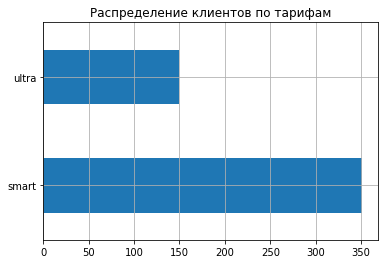

In [31]:
users['tariff'].value_counts().plot(kind='barh', grid=True, title='Распределение клиентов по тарифам');

In [32]:
# создаем таблицу с разбивкой по пользователям с нужными данными
usersinfo = merged.pivot_table(index=['user_id', 'tariff'], values = ['total_revenue', 'month', 'call_sum', 'mb_sum', 
                   'message_count'],
                   aggfunc={'month': 'count', 'total_revenue': 'sum', 
                   'call_sum': 'sum', 'mb_sum': 'sum', 'message_count': 'sum'}).reset_index().rename({
                   'month': 'month_active'}, axis=1)

# меняем типы данных для визуальной чистоты 

usersinfo['call_sum'] = usersinfo['call_sum'].astype(int)
usersinfo['mb_sum'] = usersinfo['mb_sum'].astype(int)
usersinfo['message_count'] = usersinfo['message_count'].astype(int)

In [33]:
usersinfo.head()

,user_id,tariff,call_sum,mb_sum,message_count,month_active,total_revenue
0,1000,ultra,2566,107492,496,8,15600
1,1001,smart,844,32505,0,2,1900
2,1002,smart,1517,116183,70,7,7250
3,1003,ultra,3822,57329,380,5,9750
4,1004,ultra,987,149172,1192,8,15600


In [34]:
# создаем срезы с юзерами по тарифам
smartusers = merged.query('tariff == "smart"')
ultrausers = merged.query('tariff == "ultra"')

In [35]:
print(smartusers['total_revenue'].median(), 'медианный доход в месяц с абонента тарифа Smart')
print(ultrausers['total_revenue'].median(), 'медианный доход в месяц с абонента тарифа Ultra')

1037.0 медианный доход в месяц с абонента тарифа Smart
1950.0 медианный доход в месяц с абонента тарифа Ultra


In [36]:
print(smartusers['total_revenue'].median() - 550, 'медианный доход в месяц с абонента тарифа Smart без учета аб/платы')
print(ultrausers['total_revenue'].median() - 1950, 'медианный доход в месяц с абонента тарифа Ultra без учета аб/платы')

487.0 медианный доход в месяц с абонента тарифа Smart без учета аб/платы
0.0 медианный доход в месяц с абонента тарифа Ultra без учета аб/платы


In [37]:
print(usersinfo.query('tariff == "smart"')['total_revenue'].median(), 'медианный годовой доход с абонента тарифа Smart')
print(usersinfo.query('tariff == "ultra"')['total_revenue'].median(), 'медианный годовой доход с абонента тарифа Ultra')

7287.0 медианный годовой доход с абонента тарифа Smart
13650.0 медианный годовой доход с абонента тарифа Ultra


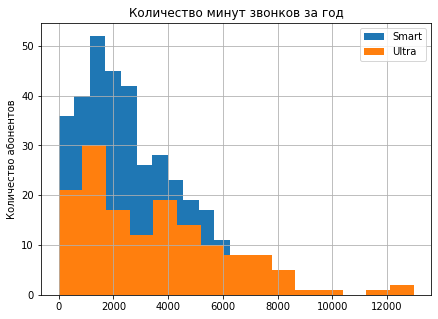

In [38]:
smartusers.groupby('user_id')['call_sum'].sum().hist( bins=15, figsize=(7,5), legend=True);

ultrausers.groupby('user_id')['call_sum'].sum().plot(kind='hist', bins=15, figsize=(7,5), grid=True);
plt.title('Количество минут звонков за год');
plt.ylabel('Количество абонентов');
plt.legend(['Smart', 'Ultra']);

In [74]:
! conda list -e

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: linux-64
_libgcc_mutex=0.1=conda_forge
_openmp_mutex=4.5=0_gnu
absl-py=0.11.0=pypi_0
alembic=1.4.2=pyh9f0ad1d_0
astor=0.8.1=pypi_0
async_generator=1.10=py_0
attrs=19.1.0=pypi_0
backcall=0.2.0=pyh9f0ad1d_0
beautifulsoup4=4.8.0=pypi_0
bleach=3.1.5=pyh9f0ad1d_0
blinker=1.4=py_1
blis=0.7.4=pypi_0
boto3=1.17.7=pypi_0
botocore=1.20.7=pypi_0
brotlipy=0.7.0=py37hb5d75c8_1001
ca-certificates=2020.12.5=ha878542_0
cached-property=1.5.2=pypi_0
cachetools=4.2.1=pypi_0
catalogue=1.0.0=pypi_0
catboost=0.20.2=pypi_0
certifi=2020.12.5=py37h89c1867_1
certipy=0.1.3=py_0
cffi=1.14.4=py37h11fe52a_0
chardet=3.0.4=py37he5f6b98_1008
click=7.1.2=pypi_0
combo=0.1.2=pypi_0
conda=4.9.2=py37h89c1867_0
conda-package-handling=1.7.2=py37hb5d75c8_0
configurable-http-proxy=4.2.1=node13_he01fd0c_0
cryptography=3.2.1=py37hc72a4ac_0
cycler=0.10.0=pypi_0
cymem=2.0.5=pypi_0
dawg-python=0.7.2=pypi_0
decorator=

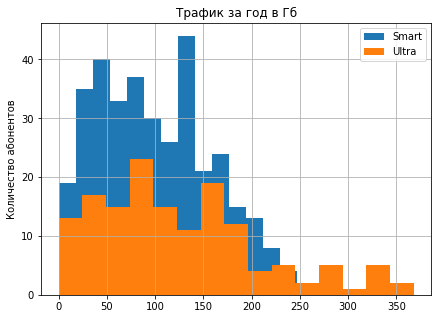

In [39]:
(smartusers.groupby('user_id')['mb_sum'].sum() / 1024).hist( bins=15, figsize=(7,5), legend=True);

(ultrausers.groupby('user_id')['mb_sum'].sum() / 1024).plot(kind='hist', bins=15, figsize=(7,5), grid=True);
plt.title('Трафик за год в Гб');
plt.ylabel('Количество абонентов');
plt.legend(['Smart', 'Ultra']);

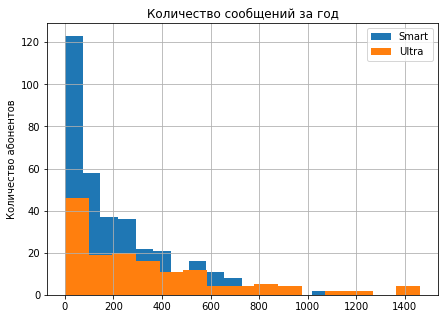

In [40]:
smartusers.groupby('user_id')['message_count'].sum().hist(bins=15, figsize=(7,5), legend=True);

ultrausers.groupby('user_id')['message_count'].sum().plot(kind='hist', bins=15, figsize=(7,5), grid=True);
plt.title('Количество сообщений за год');
plt.ylabel('Количество абонентов');
plt.legend(['Smart', 'Ultra']);

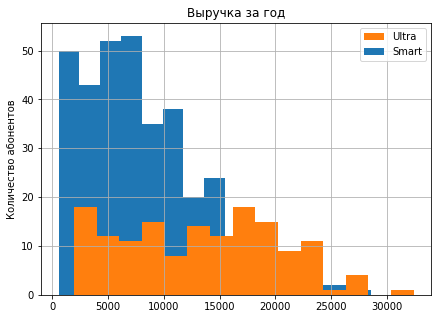

In [41]:
smartusers.groupby('user_id')['total_revenue'].sum().hist(bins=15, figsize=(7,5));

ultrausers.groupby('user_id')['total_revenue'].sum().plot(kind='hist', bins=15, figsize=(7,5), grid=True);
plt.title('Выручка за год');
plt.ylabel('Количество абонентов');
plt.legend(['Ultra', 'Smart']);

<a id='cell301'></a> 

In [42]:
# юзеры с самым большим уровнем выручки за год
merged.groupby(['user_id', 'tariff'])[['total_revenue']].sum().sort_values('total_revenue', ascending=False).head(15)

,,total_revenue
user_id,tariff,
1240,ultra,32400
1496,smart,28551
1185,ultra,28200
1385,ultra,28050
1180,ultra,26550
1292,ultra,26400
1227,smart,26179
1072,smart,26117
1168,ultra,25350


In [43]:
print((merged.query('tariff == "ultra"')['total_revenue'].sum() /1000000).round(2),'млн общая выручка с абонентов тарифа Ultra')
print((merged.query('tariff == "smart"')['total_revenue'].sum() /1000000).round(2),'млн общая выручка с абонентов тарифа Smart')

2.04 млн общая выручка с абонентов тарифа Ultra
2.89 млн общая выручка с абонентов тарифа Smart


In [44]:
# создаем таблицу для рассчетов стандартного отклонения и дисперсии
userstats = merged.pivot_table(index=['user_id', 'tariff'], values=['call_sum', 'mb_sum', 'message_count']).reset_index()

In [45]:
smartstats = userstats.query('tariff == "smart"')
ultrastats = userstats.query('tariff == "ultra"')

print('Стандартное отклонение для абонентов тарифа Smart')
display(np.std(smartstats, ddof=1))
print('Стандартное отклонение для абонентов тарифа Ultra')
display(np.std(ultrastats, ddof=1))

Стандартное отклонение для абонентов тарифа Smart


user_id           145.033439
call_sum          143.473707
mb_sum           3581.630188
message_count      24.849738
dtype: float64

Стандартное отклонение для абонентов тарифа Ultra


user_id           143.031861
call_sum          268.338363
mb_sum           8178.259984
message_count      43.390612
dtype: float64

In [46]:
print('Дисперсия для абонентов тарифа Smart')
display(np.var(smartstats, ddof=1))
print('Дисперсия для абонентов тарифа Ultra')
display(np.var(ultrastats, ddof=1))

Дисперсия для абонентов тарифа Smart


user_id          2.103470e+04
call_sum         2.058470e+04
mb_sum           1.282807e+07
message_count    6.175095e+02
dtype: float64

Дисперсия для абонентов тарифа Ultra


user_id          2.045811e+04
call_sum         7.200548e+04
mb_sum           6.688394e+07
message_count    1.882745e+03
dtype: float64

In [47]:
# мини-функция для правила 3 сигм

def std_counter(column):
    minus3std = column.mean() - 3 * column.std()
    plus3std = column.mean() + 3 * column.std()
    return minus3std, plus3std

In [48]:
print('Значения от -3 до +3 сигм абонентов тарифа Ultra')
print('================================================')
print(std_counter(ultrausers['call_sum']),'— по длительности звонков')
print(std_counter(ultrausers['mb_sum']),'— по интернет-трафику')
print(std_counter(ultrausers['message_count']),'— по количеству сообщений')

Значения от -3 до +3 сигм абонентов тарифа Ultra
(-375.3261575456112, 1466.228365747504) — по длительности звонков
(-10169.403982797001, 49542.938341771354) — по интернет-трафику
(-76.63207280317309, 198.95408538178944) — по количеству сообщений


In [49]:
print('Значения от -3 до +3 сигм абонентов тарифа Smart')
print('================================================')
print(std_counter(smartusers['call_sum']),'— по длительности звонков')
print(std_counter(smartusers['mb_sum']),'— по интернет-трафику')
print(std_counter(smartusers['message_count']),'— по количеству сообщений')

Значения от -3 до +3 сигм абонентов тарифа Smart
(-148.91387541053132, 987.0398313259609) — по длительности звонков
(-1370.0007943518285, 33842.94603672167) — по интернет-трафику
(-41.64740520770307, 119.08028762185499) — по количеству сообщений


<a id='cell302'></a>

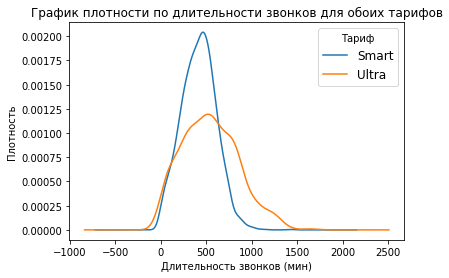

In [50]:
# графики плотности по звонкам для обоих тарифов

smartusers['call_sum'].plot.kde();
ultrausers['call_sum'].plot.kde();

plt.legend(prop={'size': 12}, labels=['Smart', 'Ultra'], title = 'Тариф' )
plt.title('График плотности по длительности звонков для обоих тарифов')
plt.xlabel('Длительность звонков (мин)')
plt.ylabel('Плотность');

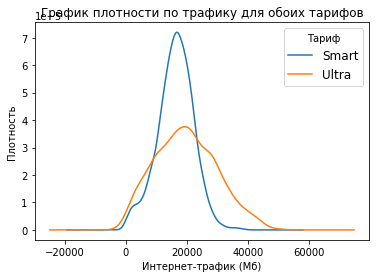

In [51]:
# графики плотности по трафику для обоих тарифов

smartusers['mb_sum'].plot.kde();
ultrausers['mb_sum'].plot.kde();

plt.legend(prop={'size': 12}, labels=['Smart', 'Ultra'], title = 'Тариф' )
plt.title('График плотности по трафику для обоих тарифов')
plt.xlabel('Интернет-трафик (Мб)')
plt.ylabel('Плотность');

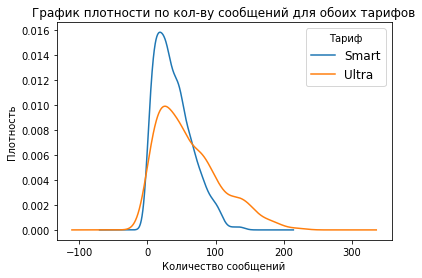

In [52]:
# графики плотности по сообщениям для обоих тарифов

smartusers['message_count'].plot.kde();
ultrausers['message_count'].plot.kde();

plt.legend(prop={'size': 12}, labels=['Smart', 'Ultra'], title = 'Тариф' )
plt.title('График плотности по кол-ву сообщений для обоих тарифов')
plt.xlabel('Количество сообщений')
plt.ylabel('Плотность');

In [53]:
# функция для фильтрации выбросов

def outliers(df, column, graphic=0, x = 7, y = 7):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    iqr_test = (df[column] >= (q1 - 1.5 * iqr)) & (df[column] <= (q3 + 1.5 * iqr))
    if graphic == 1:
        return df.loc[iqr_test].boxplot([column], figsize=(x,y))
    else:
        return df.loc[iqr_test]

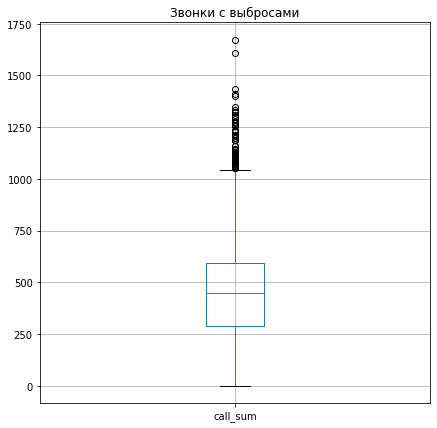

In [54]:
# боксплот с выбросами для примера
merged.boxplot('call_sum', figsize=(7,7));
plt.title('Звонки с выбросами');

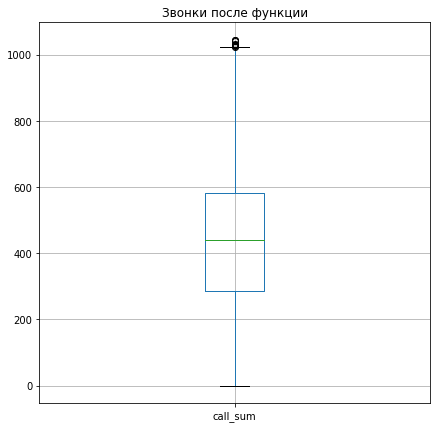

In [55]:
# боксплот после функции 
outliers(merged, 'call_sum', 1); 
plt.title('Звонки после функции');

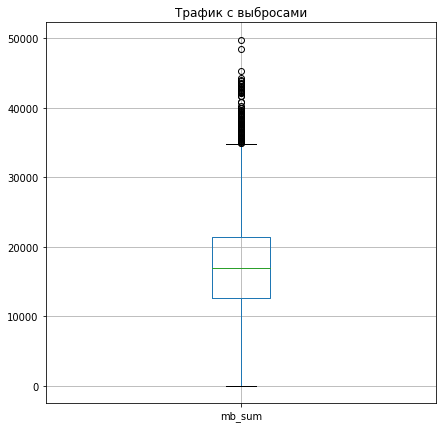

In [56]:
merged.boxplot('mb_sum', figsize=(7,7));
plt.title('Трафик с выбросами');

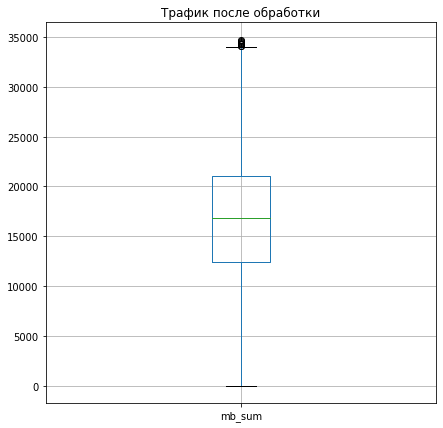

In [57]:
outliers(merged, 'mb_sum', 1); 
plt.title('Трафик после обработки');

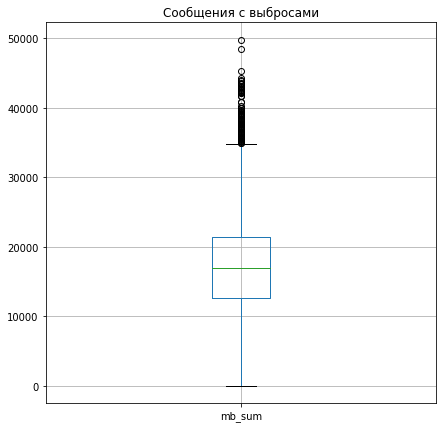

In [58]:
merged.boxplot('mb_sum', figsize=(7,7));
plt.title('Сообщения с выбросами');

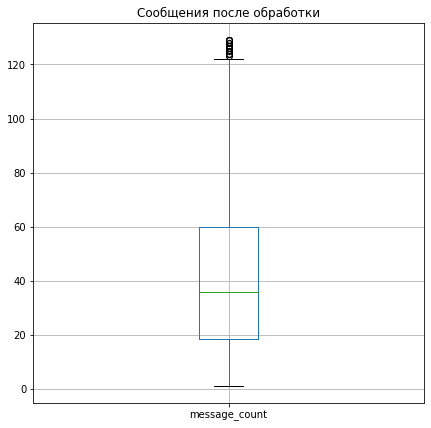

In [59]:
outliers(merged, 'message_count', 1); 
plt.title('Сообщения после обработки');

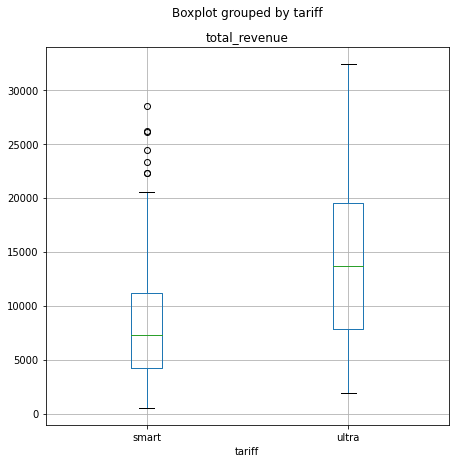

In [60]:
# диаграмма размаха для обоих тарифов
usersinfo.boxplot('total_revenue', by='tariff', figsize=(7,7));

In [61]:
tariffs = tariffs.rename({'tariff_name':'tariff'}, axis=1)
merged

,user_id,month,call_count,call_sum,internet_count,mb_sum,message_count,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_revenue,internet_revenue,message_revenue,total_revenue
0,1000,5.0,22.0,159.0,5.0,2256.0,22.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950,0,0,1950
1,1000,6.0,43.0,172.0,49.0,23257.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950,0,0,1950
2,1000,7.0,47.0,340.0,29.0,14016.0,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950,0,0,1950
3,1000,8.0,52.0,408.0,29.0,14070.0,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950,0,0,1950
4,1000,9.0,58.0,466.0,27.0,14581.0,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950,0,0,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,NaN,63.0,19588.0,21.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,550,1000,0,1550
3212,1489,11.0,NaN,NaN,55.0,17516.0,20.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,550,600,0,1150
3213,1489,12.0,NaN,NaN,51.0,17341.0,35.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,550,400,0,950
3214,1128,NaN,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1950,0,0,1950


In [62]:
# # объединяем таблицу с данными по тарифами с таблицей с пользователями
tariffs = tariffs.rename({'tariff_name':'tariff'}, axis=1)
tariff_stats = merged.merge(tariffs, on='tariff', how='outer')

In [63]:
# создадим новые столбцы с долями использования пакетов звонков, интернета и смс 

tariff_stats['usedcalls_share'] = tariff_stats['call_sum'] / tariff_stats['minutes_included'] * 100
tariff_stats['usedmb_share'] = tariff_stats['mb_sum'] / tariff_stats['mb_per_month_included'] * 100
tariff_stats['usedmsg_share'] = tariff_stats['message_count'] / tariff_stats['messages_included'] * 100

In [64]:
# количество пользователей в базе, которые не используют хотя бы один пакет полностью 
tariff_stats.query('usedcalls_share < 100 | usedmb_share < 100 | usedmsg_share < 100')['user_id'].nunique()

495

In [65]:
# количество пользователей тарифов, не использующих хотя бы один пакет на 100%

notused = tariff_stats.query('usedcalls_share < 100 | usedmb_share < 100 | usedmsg_share < 100')
notused.groupby('tariff')[['user_id']].nunique()

,user_id
tariff,
smart,347
ultra,148


In [66]:
print('Пользователи, не использовавшие пакет минут:', tariff_stats.query('usedcalls_share < 100')['user_id'].nunique())
print('Пользователи, не использовавшие пакет интернета:', tariff_stats.query('usedmb_share < 100')['user_id'].nunique()) 
print('Пользователи, не использовавшие пакет сообщений:', tariff_stats.query('usedmsg_share < 100')['user_id'].nunique())

Пользователи, не использовавшие пакет минут: 473
Пользователи, не использовавшие пакет интернета: 460
Пользователи, не использовавшие пакет сообщений: 396


Всего в базе 500 пользователей, из них: 351 абоненты тарифа Smart, 149 - тарифа Ultra. Несмотря на значительно меньшую абонентскую базу, засчет высокой стоимости абонентской платы пользователи тарифа Ultra принесли 40% от общей выручки, чуть больше 2 млн рублей. Абоненты тарифа Smart потратили 2.89 млн рублей, то есть, 60% от общей выручки, соответственно.

При этом большая часть выручки от пользователей тарифа Ultra приходится именно на абонентскую плату. Медианный доход месячный доход без учета абонентской платы составил 0 рублей. Преобладающее большинство пользователей тарифа Ultra не выходят за рамки предоставляемых пакетов и не тратят дополнительно. Однако среди [топ-15 клиентов](#cell301) с самыми высокими расходами на связь, большую часть занимают абоненты тарифа Ultra (11 мест), при это начиная с 13 места и выше суммы уже превышают максимально возможную годовую выручку только с абонентской платы (23400 рублей). 

Почти все пользователи обоих тарифов не расходуют хотя бы один пакет, включенный в абонетскую плату на 100%. Большая часть пользователей не использует пакеты минут и сообщений полностью. Чуть лучше ситуация с пакетов СМС, однако и там большая часть пакетов остается неизрасходованной.

Таким образом, 1 абонент тарифа Ultra приносит оператору столько же денег сколько почти 2 клиента тарифа Smart.

На [графиках плотности](#cell302) видно, что в целом данные по пользователям распределены нормально. Для обоих тарифов данные по отправленным сообщениям немного больше скошены вправо, особенно это заметно для тарифа Ultra.



## 4. Проверка гипотез
<a id='cell4'></a> 

In [67]:
# сохраняем нужные срезы юзеров по тарифам и общей выручке для удобства рассчетов

s = usersinfo.query('tariff == "smart"')['total_revenue']
u = usersinfo.query('tariff == "ultra"')['total_revenue']
s_clean = outliers(usersinfo.query('tariff == "smart"'), 'total_revenue')['total_revenue']
u_clean = outliers(usersinfo.query('tariff == "ultra"'), 'total_revenue')['total_revenue']

# для понимания выводим средние данные по выручке 

print(round(s.mean(), 2),': cредняя выручка с абонентов тарифа Smart за год')
print(round(u.mean(), 2),': cредняя выручка с абонентов тарифа Ultra за год')
print(round(s_clean.mean(), 2),': cредняя выручка с абонентов тарифа Smart за год после обработки')
print(round(u_clean.mean(), 2),': cредняя выручка с абонентов тарифа Ultra за год после обработки')

8223.65 : cредняя выручка с абонентов тарифа Smart за год
13704.36 : cредняя выручка с абонентов тарифа Ultra за год
7887.43 : cредняя выручка с абонентов тарифа Smart за год после обработки
13704.36 : cредняя выручка с абонентов тарифа Ultra за год после обработки


<a id='cell401'></a>

In [68]:
# t-test первой гипотезы на одной выборке

our_value = 8223.65 # средняя выручка с абонента тарифа Smart за год(с ней будем сравнивать нашу выборку юзеров тарифа Ultra)
our_value_clean = 7887.43 # средняя выручка с абонента тарифа Smart за год после удаления выбросов
alpha = 0.05

results = st.ttest_1samp(u, our_value) 
results_clean = st.ttest_1samp(u_clean, our_value_clean)

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print()    
print('p-значение: ', results_clean.pvalue)

if results_clean.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")    

p-значение:  1.886955871960231e-17
Отвергаем нулевую гипотезу

p-значение:  5.2997453596577345e-19
Отвергаем нулевую гипотезу


In [69]:
# t-test первой гипотезы на двух выборках между собой

alpha = 0.05

resultsind = st.ttest_ind(s, u) 
resultsind_clean = st.ttest_ind(s_clean, u_clean) 

print('p-значение: ', resultsind.pvalue)
if resultsind.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")  
print()    
print('p-значение: ', resultsind_clean.pvalue)

if resultsind_clean.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")      

p-значение:  1.037647934216547e-19
Отвергаем нулевую гипотезу

p-значение:  1.0452682189443917e-23
Отвергаем нулевую гипотезу


In [70]:
# создаем таблицу с разбивкой по пользователям и городам с нужными данными
forcity = merged.pivot_table(index=['user_id', 'city'], values = ['total_revenue', 'month', 'call_sum', 'mb_sum', 
                   'message_count'], aggfunc={'month': 'count', 'total_revenue': 'sum', 
                   'call_sum': 'sum', 'mb_sum': 'sum', 'message_count': 'sum'}).reset_index()

# меняем типы данных для визуальной чистоты
forcity['call_sum'] = forcity['call_sum'].astype(int)
forcity['mb_sum'] = forcity['mb_sum'].astype(int)
forcity['message_count'] = forcity['message_count'].astype(int)

In [71]:
# создаем срезы юзеров Москва/регионы для проверки второй гипотезы

msk = forcity.query('city == "Москва"')['total_revenue']
others = forcity.query('city != "Москва"')['total_revenue']
msk_clean = outliers(forcity.query('city == "Москва"'), 'total_revenue')['total_revenue']
others_clean = outliers(forcity.query('city != "Москва"'), 'total_revenue')['total_revenue']

print(round(msk.mean(), 2),': cредняя выручка с абонентов из Москвы за год')
print(round(others.mean(), 2),': cредняя выручка с абонентов из других регионов за год')
print(round(msk_clean.mean(), 2),': cредняя выручка с абонентов из Москвы за год после удаления выбросов')
print(round(others_clean.mean(), 2),': cредняя выручка с абонентов из других регионов за год после удаления выбросов')

9571.13 : cредняя выручка с абонентов из Москвы за год
9927.45 : cредняя выручка с абонентов из других регионов за год
9382.57 : cредняя выручка с абонентов из Москвы за год после удаления выбросов
9824.46 : cредняя выручка с абонентов из других регионов за год после удаления выбросов


In [72]:
# t-test второй гипотезы на одной выборке

mean_value = 9571.13 # средняя выручка с абонентов из Москвы за год(с ней будем сравнивать нашу выборку юзеров из регионов)
mean_value_clean = 9382.57
alpha = 0.05

results_msk = st.ttest_1samp(others, mean_value) 
print('p-значение: ', results_msk.pvalue)
if results_msk.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print()    
results_msk_clean = st.ttest_1samp(others_clean, mean_value_clean) 
print('p-значение: ', results_msk_clean.pvalue)

if results_msk_clean.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")    

p-значение:  0.26311124667429653
Не получилось отвергнуть нулевую гипотезу

p-значение:  0.15615449481314544
Не получилось отвергнуть нулевую гипотезу


In [73]:
# t-test второй гипотезы на двух выборках между собой

alpha = 0.05

resultsind_msk = st.ttest_ind(msk, others)
resultsind_msk_clean = st.ttest_ind(msk_clean, others_clean)

print('p-значение: ', resultsind_msk.pvalue)
if resultsind_msk.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print()

print('p-значение: ', resultsind_msk_clean.pvalue)

if resultsind_msk_clean.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.6212812931717919
Не получилось отвергнуть нулевую гипотезу

p-значение:  0.5309357043877707
Не получилось отвергнуть нулевую гипотезу


В описании проекта указана необходимость проверить две гипотезы: 
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Для первой мы можем сформулировать нулевую гипотезу: **средняя выручка абонентов тарифов Ultra и Smart одинакова** (альтернативная гипотеза уже сформулирована).

Для второй же, нулевая гипотеза звучит так: **средняя выручка пользователей из Москвы и пользователей из других регионов одинакова и не различается** (опять же альтернативная гипотеза уже сформулирована).

Обе альтернативные гипотезы двухсторонние, оставил их как есть и не стал менять.

В данном случае, нам подходит t-test для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам. Также был проведен t-test по одной выборке, где в качестве ожидаемого значения установлено среднее значение выручки абонентов одного из тарифов.  

После удаления выбросов результаты существенно не изменились. P-value, конечно, незначительно изменились, однако на гипотезах это не сказалось и средние значения изменились минимально.

По результатам обоих тестов первой [гипотезы](#cell401) получены p-value, позволяющие однозначно опровергнуть нулевую гипотезу. Средние и медианные значения выручки также демонстрируют, что средняя выручка различается существенно. Мы видим, что выручка у пользователей тарифа Ultra почти в 2 раза больше. 

Результаты обоих тестов по второй [гипотезе](#cell402) показывают противоположный результат: у нас нет поводов отвергать нулевую гипотезу, то есть, средняя выручка абонентов из Москвы и других регионов, скорее всего, мало отличается. 

## 5. Общий вывод
<a id='cell5'></a> 

По результатам проведенного анализа ответить на вопрос какой тариф лучше все еще сложно, но сказать какой тариф приносит больше денег легко. 

Данные 500 пользователей показывают, что если судить строго по суммам, то больше денег оператору приносит тариф Smart, 2.89 млн рублей против 2.03. Проблема заключается в том, что абонентов тарифа Ultra существенно меньше, а денег выручка каждого из абонентов больше, чем у пользователей тарифа Smart почти в два раза. 

Более того, у абонентов обоих тарифов достаточно разные сценарии использования связи: у тарифа Ultra пакеты предоставляют большее количество возможностей для абонентов и они, в свою очередь, могут меньше тратить на допуслуги. 50% клиентов тарифа Ultra не тратят ничего кроме ежемесячной абонентской платы, тогда как абоненты Smart в среднем тратят на связь сумму даже большую, чем абонентская плата ~ 700 рублей (медиана чуть ниже этой суммы, около 450 рублей).

Средний чек на мобильную связь в 2019 году в России составлял чуть менее 400 рублей, согласно [данным](https://rg.ru/2019/09/11/skolko-rossiiane-tratiat-na-bytovye-uslugi.html) Яндекс.Деньги. Данные в нынешнем исследовании показывают гораздо более высокий средний чек.

Проверка гипотез, предлагаемых в описании проекта показала разные результаты: гипотеза о том, что средняя выручка у абонентов разных тарифов различается не была отвергнута и разница действительно присутствует, а гипотеза о разнице выручки в Москве и остальных регионах оказалась не очень состоятельной, данные это не подтверждают.

Мы не можем утверждать, что ситуация в точности повторится для всей базы клиентов оператора, однако имеющаяся выборка показывает, что один абонент тарифа Ultra выгоднее, чем один абонент тарифа Smart почти в 2 раза. Однако высокая стоимость абонентской платы (более чем в 3 раза от тарифа Smart), может выступать ограничением для роста клиентской базы этого тарифа. 

Большая часть объема пакетов тарифа Ultra не используется абонентами, медианы звонков, интернет-трафика и СМС в разы ниже лимитов. При этом, если наиболее близко к лимитам использование мобильного интернета. Звонки почти в 6 раз меньше лимита, в среднем каждый абонент не использует больше 2,5 тысяч минут каждый месяц и расходует в 16 раз меньше смс сообщений, чем включено в пакет.

97% пользователей не расходуют на 100% хотя бы один из предоставляемых им в рамках тарифа пакетов, причес ситуация полностью идентичная для обоих тарифов. 

Возможно, снижение стоимости абонентской платы Ultra засчет уменьшения объемов предоставляемых пакетов позволит привлечь больше клиентов, при этом увеличив у них расход на допуслуги. Альтернативой может стать введение промежуточного тарифа, который сможет привлечь значительную клиентскую базу, представая в наиболее выгодном свете в сравнении с двумя нынешними тарифами. 

В результате исследования, однозначное утверждать, что какой-либо тариф лучше другого нельзя, однако имеющиеся данные показывают, что приоритетом может стать именно тариф Ultra как тариф-флагман с точки зрения иерархии компании и, в целом, статуса, и его оптимизация для привлечения большего количества клиентов.